### 2 - Assignment: MNIST classification

(unrelated links)
- https://www.youtube.com/watch?v=ddCO2714W-o
- https://www.youtube.com/watch?v=UdADuHJUX6Q

In [90]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

In [91]:
def prepare_mnist_data(ds):
  #Uint8 to float32
  ds = ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #Flatten images into vectors
  ds = ds.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #Sloppy input normalization, [0, 255] to [-1, 1] (standart normal (gaussian) distribution)
  ds = ds.map(lambda img, target: ((img/128.)-1., target))
  #One-hot targets 
  ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #Cache progress ("deterministic"?)
  ds = ds.cache()
  #Shuffle, batch, prefetch
  ds = ds.shuffle(1000, seed=42)
  ds = ds.batch(32)
  ds = ds.prefetch(20)
  #return preprocessed dataset
  return ds

(train_ds, test_ds), ds_info = tfds.load("mnist", split=['train', 'test'], as_supervised=True, with_info=True)

# tfds.show_examples(train_ds, ds_info)
# print(ds_info)

train_ds = train_ds.apply(prepare_mnist_data)
test_ds = test_ds.apply(prepare_mnist_data);

Answers :
- Training/test images : 6,000 / 10,000
- Image shape : (28, 28,)
- Range of pixel values : (0, 255)

(unrelated links) 
- https://www.youtube.com/watch?v=upsAvKvdROY

In [92]:
from tensorflow.keras.layers import Dense
import numpy as np

#Fully connected feed-forward dnn to classify MNIST images using ’Dense’ layers
class MyNetwork(tf.keras.Model):

  def __init__(self, hidden = np.array([256, 256]), activations = None):
    super(MyNetwork, self).__init__()

    if (activations == None):
      activations = np.array(["relu" for i in range(len(hidden))])
      #Todo : Error if len(size) != len(activations)

    self.sizes = np.append(hidden, np.array([10]))
    self.activations = np.append(np.array([tf.keras.activations.get(activations[i]) for i in range(len(activations))]), tf.nn.softmax)
    #(Don't use "layers" variable name -> conflicting namespace)
    self.dense_layers = [tf.keras.layers.Dense(self.sizes[i], self.activations[i]) for i in range(len(self.sizes))]

  @tf.function
  def call(self, inputs):
    for i in range(len(self.dense_layers)):
      inputs = self.dense_layers[i](inputs)
    return inputs

In [93]:
def train_step(model, input, target, loss_function, optimizer = "adam"):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [94]:
def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [95]:
def train_mynet(epochs, model, loss, optimizer):

  train_losses = []
  test_losses = []
  test_accuracies = []
  # train_accuracies = []
  #testing once before we begin
  test_loss, test_accuracy = test(model, test_ds, loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  #check how model performs on train data once before we begin
  train_loss, train_accuracy = test(model, train_ds, loss)
  train_losses.append(train_loss)
  # train_accuracies.append(train_accuracy)


  # We train number of epochs times
  for epoch in range(epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_ds:
      train_loss = train_step(model, input, target, loss, optimizer)
      epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

  return(train_losses, test_losses, test_accuracies)

In [96]:
import matplotlib.pyplot as plt

def visualization(train_losses, test_losses, test_accuracies, train_accuracies = None):
  '''
  Visualizes accuracy and loss for training and test data using the mean of each epoch.
  Loss is displayed in a regular line , accuracy in a dotted line.
  Training data is displayed in blue , test data in red.
  Parameters
  ----------
  train_losses : numpy . ndarray
  training losses
  train_accuracies : numpy . ndarray
  training accuracies
  test_losses : numpy . ndarray
  test losses
  test_accuracies : numpy . ndarray
  test accuracies
  '''
  plt.figure ()
  line1 = plt.plot(train_losses, "b-")
  line2 = plt.plot(test_losses, "r-")
  # line3 = plt.plot(train_accuracies, "b:")
  line4 = plt.plot(test_accuracies, "r:")
  plt.xlabel("Training steps")
  plt.ylabel("Loss / Accuracy")
  # plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
  plt.legend((line1, line2, line4), ("training loss", "test loss", "test accuracy"))
  plt.show()

In [100]:
#MAIN---------------------------------------------------------------------------
#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_ds = train_ds.take(1000)
test_ds = test_ds.take(100)

cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
mse_loss = tf.keras.losses.MeanSquaredError()
poisson_loss = tf.keras.losses.Poisson()

# Variante A
hidden_architecture_A = [256, 256]
hidden_activation_functions_A = ["relu", "relu"]
learning_rate_A = 0.001
optimizer_A = tf.keras.optimizers.SGD(learning_rate_A)

loss_function_A = cross_entropy_loss
model_A = MyNetwork(hidden_architecture_A, hidden_activation_functions_A)

# Variante B
hidden_architecture_B = [256, 256]
hidden_activation_functions_B = ["relu", "relu"]
learning_rate_B = 0.003
optimizer_B = tf.keras.optimizers.Adam(learning_rate_B)

loss_function_B = cross_entropy_loss
model_B = MyNetwork(hidden_architecture_B, hidden_activation_functions_B)

# Variante C
hidden_architecture_C = [256, 300, 256]
hidden_activation_functions_C = ["relu", "relu", "relu"]
learning_rate_C = 0.003
optimizer_C = tf.keras.optimizers.Adam(learning_rate_C)

loss_function_C = cross_entropy_loss
model_C = MyNetwork(hidden_architecture_C, hidden_activation_functions_C)

# Variante D
hidden_architecture_D = [256, 300, 256]
hidden_activation_functions_D = ["relu", "relu", "relu"]
learning_rate_D = 0.003
optimizer_D = tf.keras.optimizers.Adam(learning_rate_D)

loss_function_D = poisson_loss
model_D = MyNetwork(hidden_architecture_D, hidden_activation_functions_D)

Epoch: 0 starting with accuracy 0.17
Epoch: 1 starting with accuracy 0.804375
Epoch: 2 starting with accuracy 0.8553125
Epoch: 3 starting with accuracy 0.87125
Epoch: 4 starting with accuracy 0.886875
Epoch: 5 starting with accuracy 0.885625
Epoch: 6 starting with accuracy 0.891875
Epoch: 7 starting with accuracy 0.8925
Epoch: 8 starting with accuracy 0.9040625
Epoch: 9 starting with accuracy 0.900625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f09775abb50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f09775bc1d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f09775bc710>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


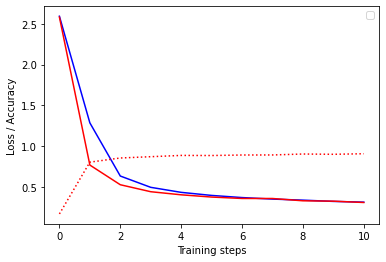

In [99]:
n_epochs = 10
train_losses, test_losses, test_accuracies = train_mynet(n_epochs, model_A, loss_function_A, optimizer_A)
visualization(train_losses, test_losses, test_accuracies)

###3 - Adjusting the hyperparameters of your model

Main hyperparameters to adjust (one by one or in combinations):
- learning rate & optimizer
- batch size
- number, size of layers 

#### Variante B : Learning rate 0.001 ➡ 0.003, optimizer SGD ➡ Adam

Epoch: 0 starting with accuracy 0.1471875
Epoch: 1 starting with accuracy 0.9325
Epoch: 2 starting with accuracy 0.9440625
Epoch: 3 starting with accuracy 0.9415625
Epoch: 4 starting with accuracy 0.949375
Epoch: 5 starting with accuracy 0.9325
Epoch: 6 starting with accuracy 0.939375
Epoch: 7 starting with accuracy 0.9509375
Epoch: 8 starting with accuracy 0.9496875
Epoch: 9 starting with accuracy 0.95


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f097411de10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f0974106490>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f09741069d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


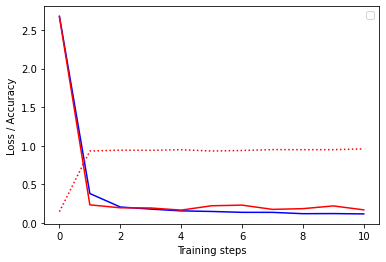

In [101]:
n_epochs = 10
train_losses, test_losses, test_accuracies = train_mynet(n_epochs, model_B, loss_function_B, optimizer_B)
visualization(train_losses, test_losses, test_accuracies)

#### Variante C : Network architecture (256, 256, 10) ➡ (256, 300, 256, 10)

Epoch: 0 starting with accuracy 0.105
Epoch: 1 starting with accuracy 0.9171875
Epoch: 2 starting with accuracy 0.931875
Epoch: 3 starting with accuracy 0.949375
Epoch: 4 starting with accuracy 0.9290625
Epoch: 5 starting with accuracy 0.935
Epoch: 6 starting with accuracy 0.949375
Epoch: 7 starting with accuracy 0.9125
Epoch: 8 starting with accuracy 0.956875
Epoch: 9 starting with accuracy 0.9453125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f09740fbc50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f0936730090>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f09367305d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


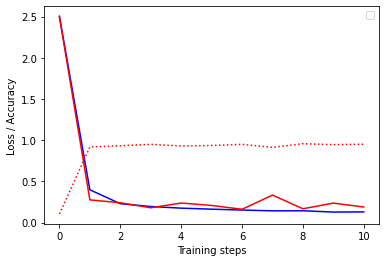

In [102]:
n_epochs = 10
train_losses, test_losses, test_accuracies = train_mynet(n_epochs, model_C, loss_function_C, optimizer_C)
visualization(train_losses, test_losses, test_accuracies)

#### Variante D : Loss function SGD ➡ Poisson 

Epoch: 0 starting with accuracy 0.0984375
Epoch: 1 starting with accuracy 0.916875
Epoch: 2 starting with accuracy 0.9309375
Epoch: 3 starting with accuracy 0.945625
Epoch: 4 starting with accuracy 0.9409375
Epoch: 5 starting with accuracy 0.93875
Epoch: 6 starting with accuracy 0.93875
Epoch: 7 starting with accuracy 0.9503125
Epoch: 8 starting with accuracy 0.9440625
Epoch: 9 starting with accuracy 0.955625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f0936eb5b90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f0954ebd210>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f0954ebd750>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


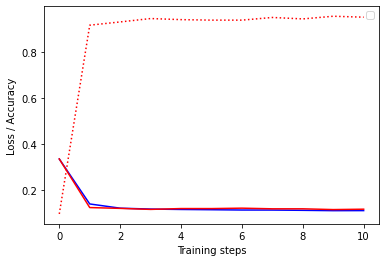

In [103]:
n_epochs = 10
train_losses, test_losses, test_accuracies = train_mynet(n_epochs, model_D, loss_function_D, optimizer_D)
visualization(train_losses, test_losses, test_accuracies)